# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.

We built up to a Chatbot with external memory that can sustain long-running conversations.

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways.

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk

In [2]:
%pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 608.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x.

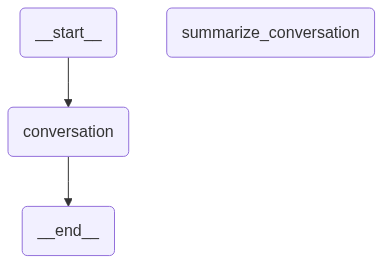

In [4]:
from IPython.display import Image, display

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):

* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [5]:
# Create a thread
config = {"configurable":{"thread_id":"1"}}
# Start conversation
for chunk in graph.stream({"messages":[HumanMessage(content="hi! I'm Tharun")]},config,stream_mode="updates"):
  print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Tharun! Nice to meet you.\n\nI'm an AI assistant. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--5a160a39-0aed-4fb4-aebe-84e6c5bffdc4-0', usage_metadata={'input_tokens': 8, 'output_tokens': 328, 'total_tokens': 336, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 304}})}}


Let's now just print the state update

In [6]:
for chunk in graph.stream({"messages":[HumanMessage(content="hi! I'm Tharun")]},config,stream_mode="updates"):
  chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

Hi Tharun! It's good to hear from you again.

How can I assist you today?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [7]:
# Start conversation, again
config = {"configurable":{"thread_id":"2"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Tharun")
for event in graph.stream({"messages":[input_message]},config,stream_mode="values"):
  for m in event['messages']:
    m.pretty_print()
  print("---"*25)

================================ Human Message =================================

hi! I'm Tharun
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Tharun
================================== Ai Message ==================================

Hi Tharun! Nice to meet you.

I'm an AI assistant, here to help you with whatever you need. How can I assist you today?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

* `event`: This is the type of event that is being emitted.
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [8]:
config = {"configurable":{"thread_id":"3"}}
input_message = HumanMessage(content="Tell me about the CSK IPL team")
async for event in graph.astream_events({"messages":[input_message]},config,version="v2"):
  print(f"Node: {event['metadata'].get('langgraph_node','')}.Type: {event['event']}. Name: {event['name']}")

Node: .Type: on_chain_start. Name: LangGraph
Node: conversation.Type: on_chain_start. Name: conversation
Node: conversation.Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation.Type: on_chat_model_stream. Name: ChatGoo

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`.

In [9]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the CSK IPL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content="The Chennai Super Kings (CSK) are one of the most successful and beloved franchises in the Indian Premier League (IPL). Here's a detailed look at the team:\n\n**1. Franchise Overview:**\n\n*   **Full Name:** Chennai Super", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--7c9a6e68-a1dd-4a9a-a560-60b92320ba4b', usage_metadata={'input_tokens': 8, 'output_tokens': 1317, 'total_tokens': 1325, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1266}})}
{'chunk': AIMessageChunk(content=' Kings\n*   **City:** Chennai, Tamil Nadu\n*   **Owner:** Chennai Super Kings Cricket Ltd. (a subsidiary of India Cements, led by N. Srinivasan)\n*   **Home Ground:** M. A', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--7c9a6e68-a1dd-4a9a-a560-60b92320ba4b', usage_metadata={'input_token_details': {'cache_read': 0}, 'output_tokens': 48, 'input_tokens': 0, 'total_tokens': 48, 'output_token_details':

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [10]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the CSK IPL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

The Chennai Super Kings (CSK) are one of the most successful and beloved franchises in the Indian Premier League (IPL). Here's a detailed look at the team:

**1. Franchise Overview:**

*   **Full Name:** Chennai Super| Kings
*   **City:** Chennai, Tamil Nadu
*   **Owner:** Chennai Super Kings Cricket Ltd. (a subsidiary of India Cements, led by N. Srinivasan)
*   **Home Ground:** M. A|. Chidambaram Stadium (Chepauk), Chennai
*   **Team Colors:** Primarily yellow, with blue accents.
*   **Mascot:** A roaring lion, often associated with the "Whistle Podu"| (Whistle Up!) slogan.
*   **Captain:** MS Dhoni (since the inception, except for a brief period in 2022 when Ravindra Jadeja captained).
*   **Head Coach:** Stephen Fleming (a| long-standing and highly successful partnership with Dhoni).

**2. Key Achievements & Records:**

*   **IPL Titles:** 5 (2010, 2011, 2018, 202|1, 2023) – Joint-most successful team in IPL history, alongside Mumbai Indians.
*   **Champions League T20 Titles:** 2 (

### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).